# Imports
Imports required libraries

In [144]:
from __future__ import print_function, division
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn as sklearn
from datetime import datetime
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from numpy import random
import sqlite3
%matplotlib inline

# 1) Description of the dataset
The initial database has four tables: Countries, leagues, teams, team_atts, matches, players, player_atts.

Countries - The country_id for each match (which country the match took place in)

Leagues - The league_id for each match (as each country only has one league in this set, this is identical to country_id and not needed).

Teams - Contains the id, team_api_id, team_fifa_api_id, and name of each team. The team_fifa_api_id is what the id of each team is in the FIFA games (where player/team statistics are pulled from).

Team_atts - Contains attributes about each team: their playstyle, offense, defense, etc.

Matches - This contains the bulk of the data that we want. Contains information about: who the home/away team are, which league the game took place in, which season, the data, player statistics, and betting data.

Players - Contains information about each player: their id, age, team, stature

Player_atts - Has information on the attributes of each player: their skills, strengths, weaknesses, but most importantly their player rating.

--A side note, teams and players contain both a FIFA and non-FIFA key. Matches are joined to them by non-FIFA key.--

We will now read-in the tables from the sqlite database.

In [136]:
with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    players = pd.read_sql_query("SELECT * from Player", con)
    player_atts = pd.read_sql_query("SELECT * from Player_Attributes", con)
    team_atts = pd.read_sql_query("SELECT * from Team_Attributes", con)
    teams = pd.read_sql_query("SELECT * from Team", con)


For now, we will currently only be examining betting data from bet365. Many of the betting sites included in the dataset are missing betting data on a large portion of the matches and bet365 has by far the most.

We will also drop attributes that will not be useful for what we want yet; these attributes are generally ingame statistics of the matches in general.

`league_id` is also dropped because we are not using the leagues table.

In [137]:
# Drops unneeded attributes
atts_to_drop = ['BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'GBD',
               'PSH', 'PSD', 'PSA', 'WHH', 'WHA', 'WHD', 'SJH', 'SJD', 'SJA', 'VCH',
               'VCD', 'VCA', 'GBH', 'GBA', 'BSH', 'BSD', 'BSA', 'shoton', 'goal', 'shotoff',
               'foulcommit', 'card', 'cross', 'corner', 'possession', 'league_id']
matches = matches.drop(atts_to_drop, axis=1) 
# Drops player formation values
matches = matches.drop(matches.columns[10:54], axis=1)

# Drops null values
matches = matches.dropna()
players = players.dropna()
player_atts = player_atts.dropna(subset = ['date', 'overall_rating', 'player_api_id'], axis = 0)
team_atts = team_atts.dropna()



Convert dates into datetime objects

In [138]:
matches['date'] = matches['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))
player_atts['date'] = player_atts['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %X'))

We will now replace `home_player_*` and `away_player_*` (player IDs) with their player ratings.

In [139]:
h_a_players = ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
          'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
          'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
          'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']

def process_row(row):
    matches.loc[row.name, h_a_players] = row[h_a_players].map(lambda x: find_rating_by_date(player_atts.loc[(player_atts['player_api_id'] == x)], row['date']))
def find_rating_by_date(rows, date):
    nearest_date = nearest(rows['date'], date) #The date we will use for the player ratings
    n = rows.loc[rows['date'] == nearest_date]['overall_rating']
    return rows.loc[rows['date'] == nearest_date]['overall_rating']
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x-pivot))
matches.apply(lambda x: process_row(x), axis = 1)
matches.head(5) #Check the data to confirm the replacement worked

,id,country_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
145,146,1,2008/2009,24,2009-02-27,493017,8203,9987,2,1,...,54.0,72.0,67.0,65.0,70.0,68.0,63.0,3.00,3.4,2.30
153,154,1,2008/2009,25,2009-03-08,493025,9984,8342,1,3,...,66.0,70.0,69.0,68.0,67.0,73.0,68.0,2.80,3.2,2.37
155,156,1,2008/2009,25,2009-03-07,493027,8635,10000,2,0,...,49.0,64.0,69.0,66.0,55.0,58.0,64.0,1.40,4.5,8.00
162,163,1,2008/2009,26,2009-03-13,493034,8203,8635,2,1,...,67.0,75.0,70.0,77.0,74.0,70.0,69.0,4.50,3.6,1.75
168,169,1,2008/2009,26,2009-03-14,493040,10000,9999,0,0,...,60.0,58.0,65.0,60.0,60.0,63.0,65.0,1.75,3.5,4.75


Now we are going to add a new column, `match_result` which compares `home_team_goal` and `away_team_goal` and determines who won, or if there was a tie.

In [140]:
# Replace home_team_goal and away_team_goal with home_win (0 = no/draw, 1 = yes)
def find_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 2
    if row['home_team_goal'] == row['away_team_goal']: 
        return 1
    if row['home_team_goal'] < row['away_team_goal']:
        return 0
matches.insert(9, 'match_result', -1)
matches['match_result'] = matches.apply(lambda x: find_winner(x), axis = 1)
matches = matches.drop(['home_team_goal', 'away_team_goal'], axis = 1)

Now, separate by country

In [141]:
england_matches = matches[(matches['country_id'] == 1729)]
france_matches = matches[(matches['country_id'] == 4769)]
germany_matches = matches[(matches['country_id'] == 7809)]
italy_matches = matches[(matches['country_id'] == 10257)]
netherlands_matches = matches[(matches['country_id'] == 13274)]
spain_matches = matches[(matches['country_id'] == 21518)]

# 3) Win Analysis
Fans of soccer know that certain leagues are easier to predict than others. For example, the Spanish La Liga is notoriously top-heavy, with Real Madrid and Barcelona dominating the league for the last few decades. We will now use a dummy baseline classifier to serve as baseline scores for models we will create. 

In [148]:
y_tr_eng = england_matches['match_result']
X_tr_eng = england_matches.drop(['match_result', 'date', 'season', 'B365H', 'B365A', 'B365D', 'match_result', 'country_id', 'id', 'match_api_id'], axis=1)
y_tr_spa = spain_matches['match_result']
X_tr_spa = spain_matches.drop(['match_result', 'date', 'season', 'B365H', 'B365A', 'B365D', 'match_result', 'country_id', 'id', 'match_api_id'], axis=1)
y_tr_ger = germany_matches['match_result']
X_tr_ger = germany_matches.drop(['match_result', 'date', 'season', 'B365H', 'B365A', 'B365D', 'match_result', 'country_id', 'id', 'match_api_id'], axis=1)
y_tr_ita = italy_matches['match_result']
X_tr_ita = italy_matches.drop(['match_result', 'date', 'season', 'B365H', 'B365A', 'B365D', 'match_result', 'country_id', 'id', 'match_api_id'], axis=1)

X_tr_eng, X_val_eng, y_tr_eng, y_val_eng = train_test_split(X_tr_eng, y_tr_eng, test_size = 0.2, random_state = 0)
X_tr_spa, X_val_spa, y_tr_spa, y_val_spa = train_test_split(X_tr_spa, y_tr_spa, test_size = 0.2, random_state = 0)
X_tr_ger, X_val_ger, y_tr_ger, y_val_ger = train_test_split(X_tr_ger, y_tr_ger, test_size = 0.2, random_state = 0)
X_tr_ita, X_val_ita, y_tr_ita, y_val_ita = train_test_split(X_tr_ita, y_tr_ita, test_size = 0.2, random_state = 0)


sets = zip([('English', X_tr_eng, y_tr_eng), ('Spanish', X_tr_spa, y_tr_spa),
            ('German', X_tr_ger, y_tr_ger), ('Italian', X_tr_ita, y_tr_ita)])


dc_eng = DummyClassifier(strategy = 'most_frequent')
dc_spa = DummyClassifier(strategy = 'most_frequent')
dc_ger = DummyClassifier(strategy = 'most_frequent')
dc_ita = DummyClassifier(strategy = 'most_frequent')

dc_eng.fit(X_tr_eng, y_tr_eng)
print("Baseline classification accuracy of English matches: %f" % (dc_eng.score(X_val_eng, y_val_eng)))
dc_spa.fit(X_tr_spa, y_tr_spa)
print("Baseline classification accuracy of Spanish matches: %f" % (dc_spa.score(X_val_spa, y_val_spa)))
dc_ger.fit(X_tr_ger, y_tr_ger)
print("Baseline classification accuracy of German matches: %f" % (dc_ger.score(X_val_ger, y_val_ger)))
dc_ita.fit(X_tr_ita, y_tr_ita)
print("Baseline classification accuracy of Italian matches: %f" % (dc_ita.score(X_val_ita, y_val_ita)))




Baseline classification accuracy of English matches: 0.458685
Baseline classification accuracy of Spanish matches: 0.492620
Baseline classification accuracy of German matches: 0.458947
Baseline classification accuracy of Italian matches: 0.473588


In [175]:
rfc_eng = RandomForestClassifier(n_estimators = 29, random_state = 31)
rfc_spa = RandomForestClassifier(n_estimators = 29, random_state = 31)
rfc_ger = RandomForestClassifier(n_estimators = 29, random_state = 31)
rfc_ita = RandomForestClassifier(n_estimators = 29, random_state = 31)

rfc_eng.fit(X_tr_eng, y_tr_eng)
print("Random Forest classification accuracy of English matches: %f" % (rfc_eng.score(X_val_eng, y_val_eng)))
rfc_spa.fit(X_tr_spa, y_tr_spa)
print("Random Forest classification accuracy of Spanish matches: %f" % (rfc_spa.score(X_val_spa, y_val_spa)))
rfc_ger.fit(X_tr_ger, y_tr_ger)
print("Random Forest classification accuracy of German matches: %f" % (rfc_ger.score(X_val_ger, y_val_ger)))
rfc_ita.fit(X_tr_ita, y_tr_ita)
print("Random Forest classification accuracy of Italian matches: %f" % (rfc_ita.score(X_val_ita, y_val_ita)))

Random Forest classification accuracy of English matches: 0.524452
Random Forest classification accuracy of Spanish matches: 0.518450
Random Forest classification accuracy of German matches: 0.488421
Random Forest classification accuracy of Italian matches: 0.480874


In [168]:
def find_feature_name(n):
    index = all_features.index(n)
    return X_tr_eng.columns.values[index]
all_features = list(rfc_eng.feature_importances_)
top_50_features = np.sort(rfc_eng.feature_importances_)[::-1][:50]
find_feature_name = np.vectorize(find_feature_name)
find_feature_name(top_50_features)


array(['home_player_8', 'stage', 'away_player_11', 'home_player_7',
       'away_player_4', 'away_player_8', 'home_player_9', 'home_player_10',
       'away_player_10', 'away_player_9', 'home_player_6', 'home_player_3',
       'home_player_5', 'away_player_1', 'away_player_7', 'home_player_4',
       'away_player_5', 'home_player_1', 'home_team_api_id',
       'away_player_2', 'home_player_11', 'away_player_3', 'home_player_2',
       'away_player_6', 'away_team_api_id'], 
      dtype='|S16')

In [165]:
kf_eng = KFold(X_tr_eng.index.size, n_folds = 10, shuffle=True, random_state = 0)
kf_spa = KFold(X_tr_spa.index.size, n_folds = 10, shuffle=True, random_state = 0)
kf_ger = KFold(X_tr_ger.index.size, n_folds = 10, shuffle=True, random_state = 0)
kf_ita = KFold(X_tr_ita.index.size, n_folds = 10, shuffle=True, random_state = 0)

c_space = np.logspace(-5, 5, 20)
lgr_eng = LogisticRegressionCV(Cs = c_space, cv = kf_eng, solver='lbfgs')
lgr_eng.fit(X_tr_eng, y_tr_eng)
print("Classification accuracy of Logistic Regression on English matches: %f" % (lorc_eng.score(X_val_eng, y_val_eng)))
lgr_spa = LogisticRegressionCV(Cs = c_space, cv = kf_spa, solver='lbfgs')
lgr_spa.fit(X_tr_spa, y_tr_spa)
print("Classification accuracy of Logistic Regression on Spanish matches: %f" % (lorc_spa.score(X_val_spa, y_val_spa)))
lgr_ger = LogisticRegressionCV(Cs = c_space, cv = kf_ger, solver='lbfgs')
lgr_ger.fit(X_tr_ger, y_tr_ger)
print("Classification accuracy of Logistic Regression on German matches: %f" % (lorc_ger.score(X_val_ger, y_val_ger)))
lgr_ita = LogisticRegressionCV(Cs = c_space, cv = kf_ita, solver='lbfgs')
lgr_ita.fit(X_tr_ita, y_tr_ita)
print("Classification accuracy of Logistic Regression on Italian matches: %f" % (lorc_ita.score(X_val_ita, y_val_ita)))

Classification accuracy of Logistic Regression on English matches: 0.524452
Classification accuracy of Logistic Regression on Spanish matches: 0.533210
Classification accuracy of Logistic Regression on German matches: 0.532632
Classification accuracy of Logistic Regression on Italian matches: 0.522769


The lbfgs logistic regression model performs noticeably better than the baseline classifier on the training set. 

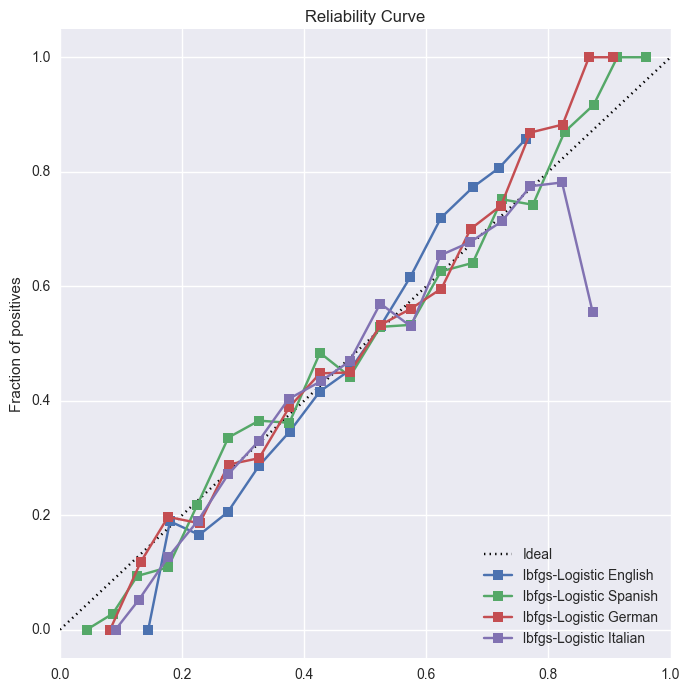

In [126]:
def reliability_curve(list_of_results):    
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.plot([0, 1], [0, 1], 'k:', label='Ideal')
    for X, y, clfname, clf in list_of_results:
        clf_probs = clf.predict_proba(X)[:,1]
        clf_fop, clf_mpv = calibration_curve(y, clf_probs, n_bins=20)
        ax.plot(clf_mpv, clf_fop, "s-", label=clfname)
        ax.legend(loc = "lower right")
    ax.set_ylabel('Fraction of positives')
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc='lower right')
    ax.set_title('Reliability Curve')
    plt.tight_layout()
    
results = [(X_tr_eng, y_tr_eng, 'lbfgs-Logistic English', lorc_eng), 
           (X_tr_spa, y_tr_spa, 'lbfgs-Logistic Spanish', lorc_spa),
           (X_tr_ger, y_tr_ger, 'lbfgs-Logistic German', lorc_ger),
           (X_tr_ita, y_tr_ita, 'lbfgs-Logistic Italian', lorc_ita)]

reliability_curve(results)

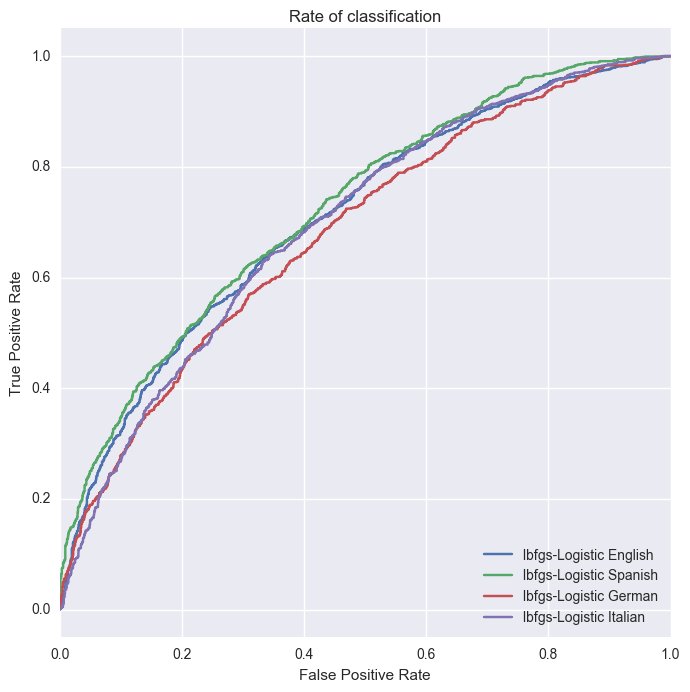

In [134]:
def roc_plot(list_of_results):
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    for X, y, clfname, clf in list_of_results:
        clf_probs = clf.predict_proba(X)[:,1]
        fpr, tpr, thresholds = roc_curve(y, clf_probs)
        ax.plot(fpr, tpr, label=clfname)
        ax.legend(loc = "lower right")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc='lower right')
    ax.set_title('Rate of classification')
    plt.tight_layout()
roc_plot(results)

In [110]:
eng_rbf = SVC(kernel = 'rbf', probability = True)
spa_rbf = SVC(kernel = 'rbf', probability = True)
ger_rbf = SVC(kernel = 'rbf', probability = True)
ita_rbf = SVC(kernel = 'rbf', probability = True)


print("Classification accuracy of RBF SVC on English matches: %f" % (np.mean(cross_val_score(eng_rbf, X_tr_eng, y_tr_eng, cv=kf_eng))))
print("Classification accuracy of RBF SVC on Spanish matches: %f" % (np.mean(cross_val_score(spa_rbf, X_tr_spa, y_tr_spa, cv=kf_spa))))
print("Classification accuracy of RBF SVC on German matches: %f" % (np.mean(cross_val_score(ger_rbf, X_tr_ger, y_tr_ger, cv=kf_ger))))
print("Classification accuracy of RBF SVC on Italian matches: %f" % (np.mean(cross_val_score(ita_rbf, X_tr_ita, y_tr_ita, cv=kf_ita))))

Classification accuracy of RBF SVC on English matches: 0.544566
Classification accuracy of RBF SVC on Spanish matches: 0.515177
Classification accuracy of RBF SVC on German matches: 0.546123
Classification accuracy of RBF SVC on Italian matches: 0.534480


RBF-kernel SVCs perform worse than logistic regression, and approximately as well as the baseline estimator does.